In [ ]:
!pip install -q contractions transformers sent2vec
!pip install -q imbalanced-learn

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 284 kB 45.4 MB/s 
     |████████████████████████████████| 106 kB 36.1 MB/s 
     |████████████████████████████████| 67 kB 1.0 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 6.5 MB 32.3 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 


In [ ]:
import numpy as np
import re
import warnings
import contractions
import pandas as pd
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sent2vec.vectorizer import Vectorizer
from collections import Counter
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn import preprocessing
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

nltk.download('stopwords')

warnings.filterwarnings("ignore")
pd.options.display.max_colwidth=None
pd.options.display.max_rows=None
pd.options.display.max_columns=None
pd.options.display.width=None
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
PUNCTUATIONS = string.punctuation
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('not')

In [ ]:
train_filename = "task2_en_training.tsv"
val_filename = "task2_en_validation.tsv"

In [ ]:
# Load data
train = pd.read_csv(train_filename, sep="\t")
validation = pd.read_csv(val_filename, sep="\t")

In [ ]:
print(f"Shape of training data is {train.shape} and validation data is {validation.shape}")

Shape of training data is (20544, 4) and validation data is (5134, 4)


In [ ]:
# Train top 5 rows
train.head().style.set_caption("Task 1: Train dataset")

,tweet_id,user_id,class,tweet
0,344266386467606528,809439366,0,"depression hurts, cymbalta can help"
1,349220537903489025,323112996,0,"@jessicama20045 right, but cipro can make things much worse...and why give bayer more of your money? they already screwed you once w/ essure"
2,351421773079781378,713100330,0,@fibby1123 are you on paxil .. i need help
3,326594278472171520,543113070,0,@redicine the lamotrigine and sjs just made chaos more vengeful and sadistic.
4,345567138376994816,138795534,0,"have decided to skip my #humira shot today. my body's having hysterics, need time to simmer down #rheum"


In [ ]:
# Drop unwanted columns
train.drop(['tweet_id', 'user_id'], axis=1, inplace=True)
validation.drop(['tweet_id', 'user_id'], axis=1, inplace=True)

In [ ]:
#@title Helper function for cleaning tweets

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_redundant_chars(text):
    pattern = re.compile(r'(&gt|&amp|&lt|wtf|fuck\'n|®|©|rt)')
    return pattern.sub('', text)

# Reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

def remove_emoticons(text):
    emoticons_pattern = re.compile(u'(' + u'|'.join(emo for emo in EMOTICONS) + u')')
    return emoticons_pattern.sub(r'', text)

def expand_contractions(text):
    return contractions.fix(text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

def remove_whitespaces(text):
    pattern = re.compile(r" +")
    return pattern.sub(" ", text).strip()

def remove_repeated_chars(text):
    return re.sub("(.)\\1{2,}", "\\1", text)

def remove_single_char(text):
    pattern = re.compile(r' ([a-zA-Z]{1}) ')
    return pattern.sub(" ", text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

In [ ]:
#@title Clean Tweets function
def clean_tweets(df, col):
    
    # Lower case
    df[col] = df[col].str.lower()

    # Remove URL's
    df[col] = df[col].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    
    # Remove Mentions and Hastags
    df[col] = df[col].apply(lambda x: remove_tags_mentions(x))

    # Remove redundant characters
    df[col] = df[col].apply(lambda x: remove_redundant_chars(x))

    # Remove emoji's
    df[col] = df[col].apply(lambda x: remove_emoji(x))

    # Remove emoticons
    df[col] = df[col].apply(lambda x: remove_emoticons(x))
    
    # Expand contractions
    df[col] = df[col].apply(lambda x: expand_contractions(x))
    
    # Remove stopwords
    df[col] = df[col].apply(lambda x: remove_stopwords(x))

    # Remove punctuations
    df[col] = df[col].apply(lambda x: remove_punctuation(x))

    # Remove repeated characters in tweet
    df[col] = df[col].apply(lambda x: remove_repeated_chars(x))

    # Remove single character within text
    df[col] = df[col].apply(lambda x: remove_single_char(x))

    # Remove extract whitespaces within tweet
    df[col] = df[col].apply(lambda x: remove_whitespaces(x))

    # Drop duplicate rows
    df.drop_duplicates(subset=['tweet'], inplace=True, keep='first')
    
    return df

In [ ]:
%%time
train = clean_tweets(train, 'tweet')
validation = clean_tweets(validation, 'tweet')

CPU times: user 4.8 s, sys: 22 ms, total: 4.82 s
Wall time: 5.79 s


## Visualizations

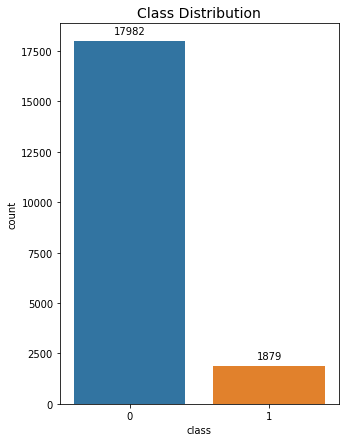

In [ ]:
# Class distribution
fig = plt.figure(figsize=(5,7))
plot = sns.countplot(train['class'])
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Class Distribution", fontsize=14)
plt.show()

In [ ]:
# Most frequent words in tweets having adverse reactions
# counter_pos = Counter([word for tweet in train[train['class'] == 1].tweet.tolist() for word in tweet.split()])

In [ ]:
# counter_pos.most_common(20)

In [ ]:
# counter_neg = Counter([word for tweet in train[train['class'] == 0].tweet.tolist() for word in tweet.split()])

In [ ]:
# counter_neg.most_common(20)

## Sentence Embeddings (Doc2vec)

In [ ]:
train_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train.tweet)]
test_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(validation.tweet)]
model = Doc2Vec(epochs=30)
model.build_vocab(train_documents)

model.train(train_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
def vector_for_learning(model, input_docs):
    # sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in input_docs])
    return targets, feature_vectors

y_train_indexs, X_train = vector_for_learning(model, train_documents)
y_valid_indexs, X_valid = vector_for_learning(model, test_documents)

### Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, train['class'])
y_pred = logreg.predict(X_valid)

print(f'Testing accuracy for movie plots {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score for movie plots: {f1_score(validation["class"], y_pred)}')

Testing accuracy for movie plots 0.8989053444945267
Testing classification report 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4189
           1       0.00      0.00      0.00       470

    accuracy                           0.90      4659
   macro avg       0.45      0.50      0.47      4659
weighted avg       0.81      0.90      0.85      4659

Testing confusion matrix 
[[4188    1]
 [ 470    0]]
Testing F1 score for movie plots: 0.0


In [ ]:
for class_weight1 in range(1,50,2):
    logreg = LogisticRegression(class_weight={0:1,1:class_weight1})
    logreg.fit(X_train, train['class'])
    y_predp = logreg.predict_proba(X_valid)
    y_pred = logreg.predict(X_valid)

    print(f'Class weight: {class_weight1}')
    print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
    print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
    print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
    print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')
    print()

Class weight: 1
Testing accuracy 0.8989053444945267
Testing classification report 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4189
           1       0.00      0.00      0.00       470

    accuracy                           0.90      4659
   macro avg       0.45      0.50      0.47      4659
weighted avg       0.81      0.90      0.85      4659

Testing confusion matrix 
[[4188    1]
 [ 470    0]]
Testing F1 score: 0.0

Class weight: 3
Testing accuracy 0.8840952994204765
Testing classification report 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4189
           1       0.22      0.06      0.09       470

    accuracy                           0.88      4659
   macro avg       0.56      0.52      0.51      4659
weighted avg       0.83      0.88      0.85      4659

Testing confusion matrix 
[[4092   97]
 [ 443   27]]
Testing F1 score: 0.09090909090909091

Class weight

### Isolation Forest

In [ ]:
logreg = IsolationForest(bootstrap=True,random_state=0)
logreg.fit(X_train, train['class'])
y_pred = logreg.predict(X_valid)

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred, average="weighted")}')

Testing accuracy 0.0901481004507405
Testing classification report 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      4189
           1       0.10      0.89      0.18       470

    accuracy                           0.09      4659
   macro avg       0.03      0.30      0.06      4659
weighted avg       0.01      0.09      0.02      4659

Testing confusion matrix 
[[   0    0    0]
 [ 447    0 3742]
 [  50    0  420]]
Testing F1 score: 0.018294303632058733


### SMOTETomek + Logistic Regression

In [ ]:
smotetomek = SMOTETomek(random_state = 0)
X_train_resample, train_resample = smotetomek.fit_resample(X_train, train['class'])

In [ ]:
logreg = LogisticRegression(random_state=0)
logreg.fit(pd.DataFrame(X_train_resample), train_resample)
y_pred = logreg.predict(pd.DataFrame(X_valid))

print(f'Testing accuracy for movie plots {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy for movie plots 0.5741575445374544
Testing classification report 
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4189
           1       0.14      0.63      0.23       470

    accuracy                           0.57      4659
   macro avg       0.54      0.60      0.47      4659
weighted avg       0.85      0.57      0.66      4659

Testing confusion matrix 
[[2381 1808]
 [ 176  294]]
Testing F1 score: 0.2286158631415241


### SMOTETomek + XGBClassifier

In [ ]:
logreg = xgb.XGBClassifier(random_state=0)
logreg.fit(pd.DataFrame(X_train_resample), train_resample)
y_pred = logreg.predict(pd.DataFrame(X_valid))

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy 0.54539600772698
Testing classification report 
              precision    recall  f1-score   support

           0       0.91      0.55      0.68      4189
           1       0.12      0.53      0.19       470

    accuracy                           0.55      4659
   macro avg       0.51      0.54      0.44      4659
weighted avg       0.83      0.55      0.63      4659

Testing confusion matrix 
[[2290 1899]
 [ 219  251]]
Testing F1 score: 0.1916030534351145


### SMOTETomek + Random Forest Classiier

In [ ]:
logreg = RandomForestClassifier(random_state=0,max_depth=5,min_samples_leaf=10,n_estimators=500)
logreg.fit(pd.DataFrame(X_train_resample), train_resample)
y_pred = logreg.predict(pd.DataFrame(X_valid))

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy 0.5380983043571582
Testing classification report 
              precision    recall  f1-score   support

           0       0.92      0.53      0.67      4189
           1       0.12      0.58      0.20       470

    accuracy                           0.54      4659
   macro avg       0.52      0.56      0.44      4659
weighted avg       0.84      0.54      0.63      4659

Testing confusion matrix 
[[2233 1956]
 [ 196  274]]
Testing F1 score: 0.20296296296296296


### SMOTETomek + SVM

In [ ]:
logreg = SVC()
logreg.fit(pd.DataFrame(X_train_resample), train_resample)
y_pred = logreg.predict(pd.DataFrame(X_valid))

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy 0.6419832582099163
Testing classification report 
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      4189
           1       0.13      0.46      0.20       470

    accuracy                           0.64      4659
   macro avg       0.52      0.56      0.49      4659
weighted avg       0.84      0.64      0.71      4659

Testing confusion matrix 
[[2776 1413]
 [ 255  215]]
Testing F1 score: 0.2049571020019066


## TF-IDf

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))

In [ ]:
cv = 5

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    SVC(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42)
]

result_cv_df = pd.DataFrame(index=range(cv * len(models)))

scorer = make_scorer(f1_score)

In [ ]:
X_train = tfidf.fit_transform(train['tweet'])
X_valid = tfidf.transform(validation['tweet'])

In [ ]:
cv_result = []

for model in models:
  model_name = model.__class__.__name__
  f1_score_cv = cross_val_score(model, X_train, train['class'], scoring=scorer, cv=cv)
  for fold_idx, score in enumerate(f1_score_cv):
    cv_result.append((model_name, fold_idx, score))
    
result_cv_df = pd.DataFrame(cv_result, columns=['model_name', 'fold_idx', 'f1_score'])

In [ ]:
result_cv_df.groupby('model_name').f1_score.mean()

model_name
LinearSVC                 0.363654
LogisticRegression        0.138724
MultinomialNB             0.042191
RandomForestClassifier    0.000000
SVC                       0.103351
Name: f1_score, dtype: float64

In [ ]:
linearSVC = LinearSVC()
linearSVC.fit(X_train, train['class'])
y_pred = linearSVC.predict(X_valid)

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy 0.9062030478643486
Testing classification report 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4189
           1       0.55      0.40      0.47       470

    accuracy                           0.91      4659
   macro avg       0.74      0.68      0.71      4659
weighted avg       0.90      0.91      0.90      4659

Testing confusion matrix 
[[4032  157]
 [ 280  190]]
Testing F1 score: 0.46511627906976744


In [ ]:
tempo = validation.reset_index(drop=True)

In [ ]:
temp_val = tempo[y_pred != tempo["class"]]
temp_val = temp_val
temp = pd.concat([temp_val.reset_index(drop=True), pd.DataFrame(y_pred[temp_val.index], columns=['y_pred'])], axis=1)

In [ ]:
temp[temp['class'] == 0]

,class,tweet,y_pred
3,0,got kind headache nicotine cure,1
6,0,trazodone not working since staed low dose wide awake majority night cutting privacy,1
8,0,worst possible day week forget vyvanse know forgot vyvanse,1
14,0,vyvanse work good idea damn,1
15,0,experienced weight gain humira why notice eat eat gaining weight,1
16,0,problem side effects paxil mom died it stopped working fuck that,1
17,0,seroquel high doses psychotics low dose helps anxiety depression insomnia 25mg finally sleep,1
24,0,still itchy everywhere rash so lamictal is,1
31,0,six hours called nap oo thanks enbrel um least slept lol oh well take mondays off writing tomorrow,1
34,0,uhm take cymbalta first time months literally feel brain exploding lol great sign,1


In [ ]:
cvalidation_check = pd.read_csv(val_filename, sep="\t")

In [ ]:
validation_check

,tweet_id,user_id,class,tweet
0,343909778008973312,464336224,0,i don't fucking need humira
1,352823276889837570,590337731,0,"my retake is next friday, if i bloody fail again then my doc is going to need to up my fluoxetine and amitriptyline dosages again! :l"
2,339867818843594756,246979971,0,"@doctorchristian scared to start fluoxetine, what's you're opinion on them? xx"
3,349294537367236611,149749939,0,"@intuitivegal1 ok, if you stopped taking the lamictal, give 90mg a week."
4,354256195432882177,54516759,0,novartis announces secukinumab (ain457) demonstrated superiority to enbrel® in head-to-head phase iii psoriasis study .…
5,352456944537178112,1267743056,1,"""u wailed all night; now y'r disembodied sobbing all damn'd day, ghost?"" • effexor-xr®discontinuation syndrome ain't exactly heaven, angel"
6,332479707004170241,273421529,0,@irapaps you're so fucking selfish. i've got lamotrigine! no more fat pills :)
7,340660708364677120,135964180,1,"not that anyone noticed, but my #ambienwithdrawl only lasted a few days. why? because i got another scrip. i need it while i'm on levaquin."
8,340523019967545344,420499836,0,"@netnewsbuzz yes dear,now take ur prozac and call for knaidels"
9,343142864148103168,1189576320,0,"popular antidepressants zoloft, prozac and paxil can lower libido and prevent orgasms"


In [ ]:
# Most frequent words in tweets having adverse reactions
counter_pos = Counter([word for tweet in validation_check[validation_check['class'] == 1].tweet.tolist() for word in tweet.split() if word.lower() not in STOPWORDS])

In [ ]:
counter_pos.most_common(20)

[("i'm", 51),
 ('like', 49),
 ('seroquel', 43),
 ('not', 41),
 ('take', 41),
 ('&amp;', 39),
 ('feel', 37),
 ('vyvanse', 36),
 ('makes', 28),
 ('get', 28),
 ('taking', 28),
 ('quetiapine', 25),
 ('day', 25),
 ("i've", 24),
 ('sleep', 22),
 ('back', 21),
 ('made', 21),
 ('humira', 20),
 ('still', 20),
 ('side', 20)]

In [ ]:
# Most frequent words in tweets having adverse reactions
counter_neg = Counter([word for tweet in validation_check[validation_check['class'] == 0].tweet.tolist() for word in tweet.split() if word.lower() not in STOPWORDS])

In [ ]:
counter_neg.most_common(50)

[('rt', 473),
 ("i'm", 399),
 ('take', 299),
 ('cymbalta', 284),
 ('not', 274),
 ('-', 272),
 ('like', 260),
 ('chemical', 259),
 ('need', 247),
 ('&amp;', 241),
 ('get', 238),
 ('vyvanse', 235),
 ('lozenge', 216),
 ('drug', 205),
 ('nicotine', 200),
 ('make', 195),
 ('seroquel', 187),
 ('prozac', 183),
 ('paxil', 153),
 ('trazodone', 153),
 ('enbrel', 149),
 ('happy', 149),
 ('found', 148),
 ('humira', 147),
 ('taking', 140),
 ('help', 138),
 ('person', 137),
 ('bananas', 136),
 ('fluoxetine', 132),
 ('drugs', 130),
 ('made', 130),
 ('contain', 130),
 ('natural', 130),
 ('know', 126),
 ('depression', 125),
 ('side', 124),
 ('one', 115),
 ('effective', 111),
 ('think', 108),
 ('got', 106),
 ('really', 105),
 ('good', 101),
 ("amgen's", 97),
 ('cipro', 95),
 ('effects', 95),
 ("i've", 93),
 ('blockbuster', 92),
 ('@anorexic0', 91),
 ('@ewdustin', 91),
 ('-generic', 91)]

In [ ]:
logreg_cv = LogisticRegression()
logreg_cv.fit(X_train, train['class'])
y_pred = logreg_cv.predict(X_valid)

print(f'Testing accuracy {accuracy_score(validation["class"], y_pred)}')
print(f'Testing classification report \n{classification_report(validation["class"], y_pred)}')
print(f'Testing confusion matrix \n{confusion_matrix(validation["class"], y_pred)}')
print(f'Testing F1 score: {f1_score(validation["class"], y_pred)}')

Testing accuracy 0.9098518995492595
Testing classification report 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4189
           1       0.72      0.18      0.28       470

    accuracy                           0.91      4659
   macro avg       0.82      0.58      0.62      4659
weighted avg       0.89      0.91      0.88      4659

Testing confusion matrix 
[[4156   33]
 [ 387   83]]
Testing F1 score: 0.28327645051194544


In [1]:
import numpy as np

In [2]:
np.mean([True,True,True,False])

0.75